# Deciphering Code with Character-Level RNN





## Dataset

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
df = pd.read_csv('../data/CaesarCipher.csv')
df

,Passwords,ciphertext,key
0,123456,567890,6
1,12345,56789,6
2,123456789,789012345,14
3,password,bmeeiadp,14
4,iloveyou,nqtajdtz,21
...,...,...,...
14343471,"xCvBnM,",tYrXjI,4
14343472,ie168,bx491,7
14343473,abygurl69,cdaiwtn69,24
14343474,a6_123,i8345,18


C:\Users\Ashwin\miniconda3\envs\Neural-Cryptanalysis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='key', ylabel='count'>

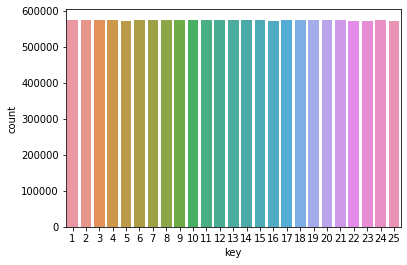

In [16]:
sns.countplot(df['key'])

In [17]:
df = df.dropna()[:120000]

C:\Users\Ashwin\miniconda3\envs\Neural-Cryptanalysis\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='key', ylabel='count'>

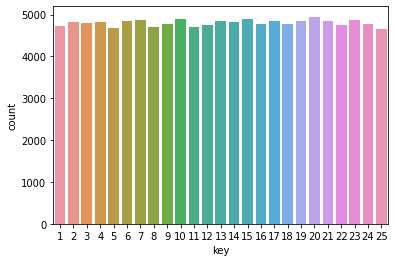

In [18]:
sns.countplot(df['key'])


In [19]:
df['Passwords'].apply(str)
df['ciphertext'].apply(str)
df

,Passwords,ciphertext,key
0,123456,567890,6
1,12345,56789,6
2,123456789,789012345,14
3,password,bmeeiadp,14
4,iloveyou,nqtajdtz,21
...,...,...,...
120022,270796,947463,3
120023,270783,947450,13
120024,27061992,16950881,1
120025,27061985,83627541,14


## Preprocessing Data

In [20]:
def tokenize(x):
    x_tk = Tokenizer(char_level=True)
    x_tk.fit_on_texts(x)                 

    return x_tk.texts_to_sequences(x), x_tk

def pad(x, length=None):
    if length is None:
        length = max([len(sentence) for sentence in x])
    
    return pad_sequences(x, maxlen=length, padding="post", truncating="post",)

### Preprocess Pipeline

In [21]:
def preprocess(x, y):
    preprocess_x, x_tk = tokenize(x)
    preprocess_y, y_tk = tokenize(y)

    preprocess_x = pad(preprocess_x)
    preprocess_y = pad(preprocess_y)

    preprocess_y = preprocess_y.reshape(*preprocess_y.shape, 1)

    return preprocess_x, preprocess_y, x_tk, y_tk

In [22]:
preproc_code_sentences, preproc_plaintext_sentences, code_tokenizer, plaintext_tokenizer = preprocess(df['Passwords'], df['ciphertext'])

print('Data Preprocessed')

Data Preprocessed


In [23]:
preproc_code_sentences[0]

array([ 3, 12, 22, 26, 27, 29,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0])

In [24]:
len(code_tokenizer.word_index)+1

78

In [25]:
len(plaintext_tokenizer.word_index)+1

41

In [26]:
plaintext_tokenizer.word_index

{'1': 1,
 'x': 2,
 'w': 3,
 'j': 4,
 'f': 5,
 'z': 6,
 'q': 7,
 'k': 8,
 'v': 9,
 'h': 10,
 'y': 11,
 'b': 12,
 'g': 13,
 'c': 14,
 'd': 15,
 'u': 16,
 'p': 17,
 't': 18,
 'm': 19,
 'l': 20,
 'n': 21,
 's': 22,
 'i': 23,
 'r': 24,
 '0': 25,
 'o': 26,
 'e': 27,
 '2': 28,
 'a': 29,
 '9': 30,
 '8': 31,
 '3': 32,
 '4': 33,
 '6': 34,
 '5': 35,
 '7': 36,
 'ã': 37,
 'à': 38,
 'â': 39,
 '¹': 40}

In [27]:
preproc_code_sentences.shape

(120000, 39)

In [28]:
preproc_plaintext_sentences.shape

(120000, 32, 1)

# LSTM

In [29]:
from keras.layers import GRU, Input, Dense, TimeDistributed, RNN, LSTM
from keras.models import Model, Sequential
from keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from keras.losses import sparse_categorical_crossentropy
import tensorflow


def simple_model(input_shape, output_sequence_length, code_vocab_size, plaintext_vocab_size):
    x = Input(shape=input_shape[1:])   
    seq = LSTM(units= 64, return_sequences = True, activation="tanh", name='Layer1')(x)
    output = TimeDistributed(Dense(units = plaintext_vocab_size, activation='softmax', name='Layer2'))(seq)
    model = Model(inputs = x, outputs = output)
    model.compile(optimizer='adam', loss= sparse_categorical_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

tmp_x = pad(preproc_code_sentences, preproc_plaintext_sentences.shape[1]) 
tmp_x = tmp_x.reshape((-1, preproc_plaintext_sentences.shape[-2], 1))     

In [30]:
tmp_x.shape

(120000, 32, 1)

In [31]:
simple_rnn_model = simple_model(
    tmp_x.shape,
    preproc_plaintext_sentences.shape[1],
    len(code_tokenizer.word_index)+1,
    len(plaintext_tokenizer.word_index)+1)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 Layer1 (LSTM)               (None, 32, 64)            16896     
                                                                 
 time_distributed (TimeDistr  (None, 32, 41)           2665      
 ibuted)                                                         
                                                                 
Total params: 19,561
Trainable params: 19,561
Non-trainable params: 0
_________________________________________________________________


In [32]:
simple_rnn_model.get_layer(name="Layer1").output.shape

TensorShape([None, 32, 64])

In [33]:
simple_rnn_model.fit(tmp_x, preproc_plaintext_sentences, batch_size=32, epochs=15, validation_split=0.3, use_multiprocessing=True)

Epoch 1/15
2625/2625 [==============================] - 33s 12ms/step - loss: 0.8094 - accuracy: 0.7859 - val_loss: 0.7859 - val_accuracy: 0.7849
Epoch 2/15
2625/2625 [==============================] - 20s 8ms/step - loss: 0.7486 - accuracy: 0.7911 - val_loss: 0.7501 - val_accuracy: 0.7880
Epoch 3/15
2625/2625 [==============================] - 20s 8ms/step - loss: 0.7220 - accuracy: 0.7927 - val_loss: 0.7347 - val_accuracy: 0.7885
Epoch 4/15
2625/2625 [==============================] - 19s 7ms/step - loss: 0.7124 - accuracy: 0.7935 - val_loss: 0.7275 - val_accuracy: 0.7887
Epoch 5/15
2625/2625 [==============================] - 18s 7ms/step - loss: 0.7072 - accuracy: 0.7939 - val_loss: 0.7231 - val_accuracy: 0.7898
Epoch 6/15
2625/2625 [==============================] - 19s 7ms/step - loss: 0.7038 - accuracy: 0.7943 - val_loss: 0.7197 - val_accuracy: 0.7902
Epoch 7/15
2625/2625 [==============================] - 19s 7ms/step - loss: 0.7014 - accuracy: 0.7945 - val_loss: 0.7180 - val_a

In [34]:
def logits_to_text(logits, tokenizer):
    index_to_words = {id: word for word, id in tokenizer.word_index.items()}
    index_to_words[0] = '<PAD>'

    return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits, 1)])
print(logits_to_text(simple_rnn_model.predict(tmp_x[:1])[0], plaintext_tokenizer))

1 2 3 6 6 6 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [35]:
df['Passwords'][0]

'123456'

# GRU

In [36]:
def simple_model1(input_shape, output_sequence_length, code_vocab_size, plaintext_vocab_size):
    x = Input(shape=input_shape[1:])   
    seq = GRU(units= 64, return_sequences = True, activation="tanh", name='Layer1')(x)  # output must be batchsize x timesteps x units
    output = TimeDistributed(Dense(units = plaintext_vocab_size, activation='softmax', name='Layer2'))(seq)
    model = Model(inputs = x, outputs = output)
    model.compile(optimizer='adam', loss= sparse_categorical_crossentropy, metrics=['accuracy'])
    model.summary()
    return model

In [37]:
simple_rnn_model1 = simple_model1(
    tmp_x.shape,
    preproc_plaintext_sentences.shape[1],
    len(code_tokenizer.word_index)+1,
    len(plaintext_tokenizer.word_index)+1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 Layer1 (GRU)                (None, 32, 64)            12864     
                                                                 
 time_distributed_1 (TimeDis  (None, 32, 41)           2665      
 tributed)                                                       
                                                                 
Total params: 15,529
Trainable params: 15,529
Non-trainable params: 0
_________________________________________________________________


In [38]:
simple_rnn_model1.fit(tmp_x, preproc_plaintext_sentences, batch_size=32, epochs=15, validation_split=0.3, use_multiprocessing=True)

Epoch 1/15
2625/2625 [==============================] - 16s 6ms/step - loss: 0.8028 - accuracy: 0.7872 - val_loss: 0.7586 - val_accuracy: 0.7873
Epoch 2/15
2625/2625 [==============================] - 15s 6ms/step - loss: 0.7236 - accuracy: 0.7920 - val_loss: 0.7329 - val_accuracy: 0.7884
Epoch 3/15
2625/2625 [==============================] - 14s 5ms/step - loss: 0.7117 - accuracy: 0.7932 - val_loss: 0.7269 - val_accuracy: 0.7889
Epoch 4/15
2625/2625 [==============================] - 14s 5ms/step - loss: 0.7066 - accuracy: 0.7938 - val_loss: 0.7219 - val_accuracy: 0.7896
Epoch 5/15
2625/2625 [==============================] - 14s 5ms/step - loss: 0.7029 - accuracy: 0.7943 - val_loss: 0.7186 - val_accuracy: 0.7902
Epoch 6/15
2625/2625 [==============================] - 14s 5ms/step - loss: 0.6998 - accuracy: 0.7948 - val_loss: 0.7165 - val_accuracy: 0.7910
Epoch 7/15
2625/2625 [==============================] - 14s 5ms/step - loss: 0.6974 - accuracy: 0.7950 - val_loss: 0.7137 - val_ac

In [39]:
print(logits_to_text(simple_rnn_model1.predict(tmp_x[:1])[0], plaintext_tokenizer))

1 2 3 7 7 7 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [40]:
df['Passwords'][0]

'123456'

# SimpleRNN

In [41]:
from keras.layers import SimpleRNN 
def simple_model2(input_shape, output_sequence_length, code_vocab_size, plaintext_vocab_size):
    x = Input(shape=input_shape[1:])      
    seq = SimpleRNN(units= 64, return_sequences = True, activation="tanh", name='Layer1')(x)   
    output = TimeDistributed(Dense(units = plaintext_vocab_size, activation='softmax', name='Layer2'))(seq)    
    model = Model(inputs = x, outputs = output)    
    model.compile(optimizer='adam', loss= sparse_categorical_crossentropy, metrics=['accuracy'])    
    model.summary()    
    return model

In [42]:
simple_rnn_model2 = simple_model2(
    tmp_x.shape,
    preproc_plaintext_sentences.shape[1],
    len(code_tokenizer.word_index)+1,
    len(plaintext_tokenizer.word_index)+1)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 1)]           0         
                                                                 
 Layer1 (SimpleRNN)          (None, 32, 64)            4224      
                                                                 
 time_distributed_2 (TimeDis  (None, 32, 41)           2665      
 tributed)                                                       
                                                                 
Total params: 6,889
Trainable params: 6,889
Non-trainable params: 0
_________________________________________________________________


In [43]:
simple_rnn_model2.fit(tmp_x, preproc_plaintext_sentences, batch_size=32, epochs=15, validation_split=0.3, use_multiprocessing=True)

Epoch 1/15
2625/2625 [==============================] - 10s 4ms/step - loss: 0.8001 - accuracy: 0.7855 - val_loss: 0.7788 - val_accuracy: 0.7855
Epoch 2/15
2625/2625 [==============================] - 9s 3ms/step - loss: 0.7433 - accuracy: 0.7914 - val_loss: 0.7488 - val_accuracy: 0.7885
Epoch 3/15
2625/2625 [==============================] - 9s 4ms/step - loss: 0.7234 - accuracy: 0.7928 - val_loss: 0.7360 - val_accuracy: 0.7888
Epoch 4/15
2625/2625 [==============================] - 9s 3ms/step - loss: 0.7149 - accuracy: 0.7935 - val_loss: 0.7299 - val_accuracy: 0.7898
Epoch 5/15
2625/2625 [==============================] - 9s 3ms/step - loss: 0.7103 - accuracy: 0.7940 - val_loss: 0.7255 - val_accuracy: 0.7899
Epoch 6/15
2625/2625 [==============================] - 9s 3ms/step - loss: 0.7070 - accuracy: 0.7943 - val_loss: 0.7228 - val_accuracy: 0.7905
Epoch 7/15
2625/2625 [==============================] - 9s 3ms/step - loss: 0.7047 - accuracy: 0.7945 - val_loss: 0.7211 - val_accuracy

In [44]:
print(logits_to_text(simple_rnn_model2.predict(tmp_x[:1])[0], plaintext_tokenizer))

1 2 3 4 4 4 <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [45]:
df['Passwords'][0]

'123456'